<a href="https://colab.research.google.com/github/Aras1703/Backprop-Heart_disease_classifier/blob/main/Heart_Disease_Classifier_using_Forprop_%26_Backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Install & Import Package**

In [ ]:
pip install jcopml

     |████████████████████████████████| 100 kB 3.4 MB/s 
  Created wheel for jcopml: filename=jcopml-1.1.14-py2.py3-none-any.whl size=33655 sha256=342909e271c749128255ad6a65496d5c6f6119cc3854dea10655137ab1ecf268
  Stored in directory: /root/.cache/pip/wheels/d9/6a/86/9a622c06f65732afe0e31c02a92fae6ab663ffd7162bcf5125
Successfully built jcopml


In [ ]:
pip install jcopdl

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16923 sha256=cf85408aad7bbd6de2b8afb9ba9983c11c79729bf014f312c4cdfe830c43d628
  Stored in directory: /root/.cache/pip/wheels/e5/78/9d/931694cba38491e16f1a94719193211fd12a7307570d9bb562
Successfully built jcopdl


In [ ]:
import numpy as np
import pandas as pd
import torch
from jcopdl.callback import Callback
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

#**Explore Data**

In [ ]:
df = pd.read_csv('heart_disease.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


,missing_value,%
age,0,0.0
sex,0,0.0
cp,0,0.0
trestbps,0,0.0
chol,0,0.0
fbs,0,0.0
restecg,0,0.0
thalach,0,0.0
exang,0,0.0
oldpeak,0,0.0


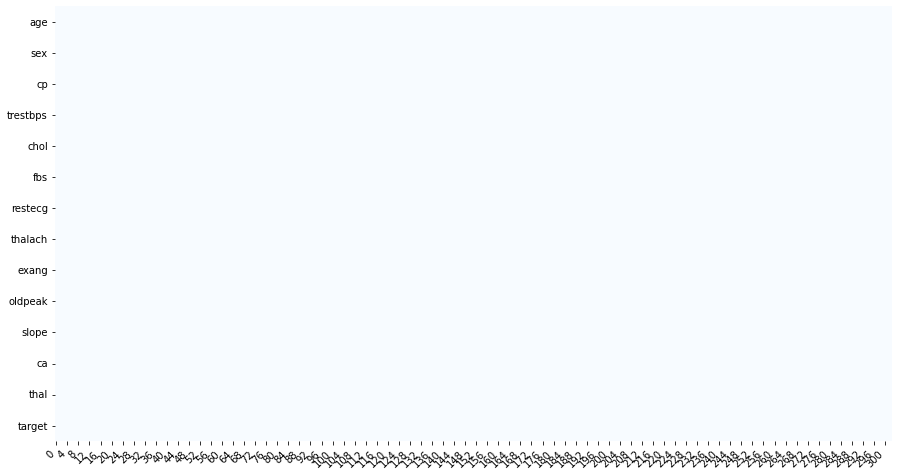

In [ ]:
plot_missing_value(df, return_df=True)

In [ ]:
# CHECK LABEL PADA DATA, APAKAH BALANCE ATAU IMBALANCE
df.target.value_counts(normalize=True)

1    0.544554
0    0.455446
Name: target, dtype: float64

#**Dataset Splitting**

In [ ]:
X = df.drop(columns='target')
y = df.target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((242, 13), (61, 13), (242,), (61,))

#**Preprocess Data**

In [ ]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
19,69,0,3,140,239,0,1,151,0,1.8,2,2,2
247,66,1,1,160,246,0,1,120,1,0.0,1,3,1
289,55,0,0,128,205,0,2,130,1,2.0,1,1,3
288,57,1,0,110,335,0,1,143,1,3.0,1,1,3
60,71,0,2,110,265,1,0,130,0,0.0,2,1,2


In [ ]:
preprocessor = ColumnTransformer([
            ('numeric', num_pipe(), ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', ]),
            ('categoric', cat_pipe(encoder='onehot'), ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])
])

In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
X_train

array([[ 69., 140., 239., ...,   0.,   1.,   0.],
       [ 66., 160., 246., ...,   1.,   0.,   0.],
       [ 55., 128., 205., ...,   0.,   0.,   1.],
       ...,
       [ 51., 120., 295., ...,   0.,   1.,   0.],
       [ 55., 130., 262., ...,   0.,   1.,   0.],
       [ 64., 180., 325., ...,   0.,   1.,   0.]])

#**Dataset & Dataloader**

In [ ]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
bs = 64

train_set = TensorDataset(X_train, y_train)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_set = TensorDataset(X_test, y_test)
testloader = DataLoader(test_set, batch_size=bs)

#**Config Model & Architecture**

In [ ]:
X_train.shape

torch.Size([242, 30])

In [ ]:
model = nn.Sequential(
    nn.Linear(30, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.LogSoftmax(1)
)
criterion = nn.NLLLoss() #negative log likelihood loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
callback = Callback(model, early_stop_patience=50)

#**Training**

In [ ]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  cost = correct = 0
  for feature, target in (dataloader):
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost / len(dataset)
  acc = correct / len(dataset)
  return cost, acc

##**Training Loop**

In [ ]:
epochs = 200
train_cost, test_cost = [], []
train_acc, test_acc = [], []
for i in range(epochs):
  cost, acc = loop_fn('train', train_set, trainloader, model, criterion, optimizer)
  train_cost.append(cost)
  train_acc.append(acc)

  with torch.no_grad():
    cost, acc = loop_fn('test', test_set, testloader, model, criterion, optimizer)
    test_cost.append(cost)
    test_acc.append(acc)

  print(f'\rEpoch : {i+1:4} / {epochs:4} | train_cost : {train_cost[-1]:.4f} | test_cost : {test_cost[-1]:.4f} | '
        f'train_acc : {train_acc[-1]:.4f} | test_acc : {test_acc[-1]:.4f}', end=' ')

Epoch :  200 /  200 | train_cost : 0.3126 | test_cost : 0.4249 | train_acc : 0.8719 | test_acc : 0.8361 

#**Predict**

In [ ]:
with torch.no_grad():
  model.eval()
  output = model(X_test)

In [ ]:
pred = output.argmax(1)
pred

tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1])

#**Accuracy**

In [ ]:
acc = (y_test == pred).to(torch.float32).mean()
acc

tensor(0.8361)

#**Loss & Accuracy Plot Manual Training**

In [ ]:
import matplotlib.pyplot as plt

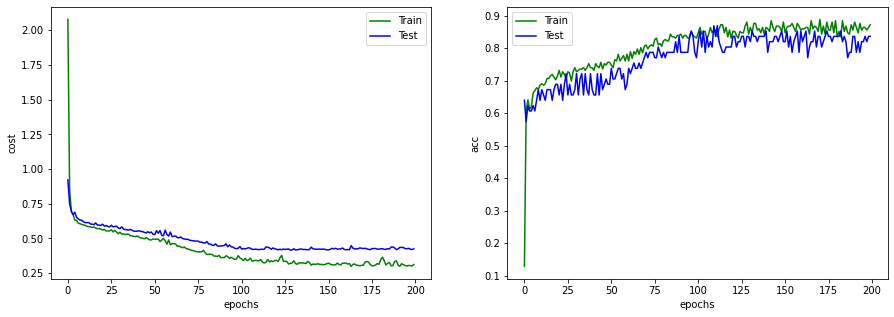

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(train_cost, 'g-', label='Train')
plt.plot(test_cost, 'b-', label='Test')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, 'g-', label='Train')
plt.plot(test_acc, 'b-', label='Test')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()